# 6.5 様々な成果指標
- 正解率以外にも、適合率、再現率、F1スコアなどの性能指標により、モデルの妥当性を評価できる。

# 6.5.1 混同行列を理解する
- 混同号列は学習アルゴリズムの性能を明らかにする行列である。
- 混同行列は分類器の真陽性、真陰性、偽陰性、偽陽性の４つの予測の個数を報告する単なる正方行列である。

In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',header=None)

In [2]:
#特徴量をX、ターゲットをyに格納
from sklearn.preprocessing import LabelEncoder
import numpy as np
X = df.loc[:,2:].values
y = df.loc[:,1].values
#クラスラベルの文字列表現を整数に変換する
le = LabelEncoder()
y = le.fit_transform(y)

In [3]:
#トレーニングデータセットとテストデータセットに分割する
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=1)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
pipe_svc = Pipeline([('scl',StandardScaler()),('cls',SVC(random_state=1))])

In [5]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train,y_train)
y_pred = pipe_svc.predict(X_test)
#テストと予測のデータから混同行列を生成
confmat = confusion_matrix(y_true=y_test,y_pred=y_pred)
print confmat

[[71  1]
 [ 2 40]]


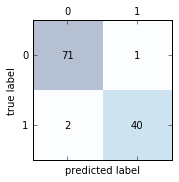

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
#図のサイズを指定
fig,ax = plt.subplots(figsize=(2.5,2.5))
#matshow関数で行列からヒートマップを描画
ax.matshow(confmat,cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]): #クラス0の繰り返し処理
    for j in range(confmat.shape[1]): #クラス1の繰り返し処理
        ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center') #件数を表示
        
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

# 6.5.2 分類モデルの適合率と再現率を最適化する
- 予測の誤分類率と正解率は、ご分類されるサンプルの個数に関する全体的な情報を提供する
$$ERR = \frac{FP+FN}{FP+FN+TP+TN}$$
$$ACC = \frac{TP+TN}{FP+FN+TP+TN} = 1-ERR$$
- 真陽性率(TPR)と偽陽性率(FPR)は不均衡なクラスの問題に特に役立つ性能指標である。（Nは全陰性、Fは全陽性を表す）
- 不均衡なクラス問題とは、クラスに偏りがある問題のことを指す。
$$FPR = \frac{FP}{N} = \frac{FP}{FP+TN}$$
$$TPR = \frac{TP}{P} = \frac{TP}{TP+FN}$$
- 例えば腫瘍の診断では、患者に適切な治療を施すには、悪性腫瘍を検出することがより重要となる。ただし、患者の不安を煽るようなことがないように、悪性として誤分類（FP）される良性腫瘍（偽陽性）の個数を減らすことも重要である。→全体の陰性のもののうち間違えて陽性だと判定されるものの割合
- 真陽性率は全体の陽性のうち、正しく特定された陽性の割合
- 適合率(PRE)と再現率(REC)は、TPRとFPRに関連する性能指標である。
- PREは陽性と予測したもののうち実際に陽性だったものの割合
$$PRE=\frac{TP}{TP+FP}$$
$$REC = TPR = \frac{TP}{P}=\frac{TP}{TP+FN}$$
- 実際にはPREとRECを組み合わせたF1スコアと呼ばれるものがよく使用される
- F1スコアはPREとRECの調和平均である。
$$F1 = 2\frac{PRE \times REC}{PRE+REC}$$

In [7]:
#適合率、再現率、F1スコアを出力
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score,f1_score
print('Precision: %.3f') % precision_score(y_true=y_test,y_pred=y_pred)
print('Recall: %.3f') % recall_score(y_true=y_test,y_pred=y_pred)
print('F1: %.3f') % f1_score(y_true=y_test,y_pred=y_pred)

Precision: 0.976
Recall: 0.952
F1: 0.964


- GridSearchCVオブジェクトは、成果率以外にも様々な性能指標を使用できる。

In [8]:
param_range = [10**i for i in range(-4,4)]
param_grid = [{'clf__C':param_range,'clf__kernel':['linear']},
              {'clf__C':param_range,'clf__gamma':param_range,'clf__kernel':['rbf']}]
#カスタムの性能指標を出力
from sklearn.metrics import make_scorer,f1_score
from sklearn.grid_search import GridSearchCV
scorer = make_scorer(f1_score,pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring=scorer,
                 cv=10)

# 6.5.3 ROC曲線をプロットする
- 受信者操作特性(Receiver Operator Characteristic:ROC)曲線は、性能に基づいて分類モデルを選択するための便利なツールである。
- 分類器の閾値を変えることによって計算される偽陽性率と真陽性率が選択の基準となる
- ROC曲線の対角線は当て推量として解釈でき、対角線を下回る分類モデルは当て推量よりも劣るとみなされる。

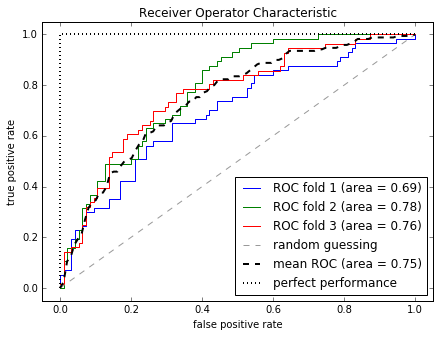

In [40]:
#Brest Cancer Wisconsinデータセットの特徴量を２津だけ使用して、腫瘍が良性か悪性かを予測する分類器のROC曲線をプロットする。
from sklearn.metrics import roc_curve,auc
from sklearn.decomposition import PCA
from scipy import interp
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold

#スケーリング、主成分分析、ロジスティック回帰を指定して、pipelineクラスをインスタンス化
pipe_lr = Pipeline([('scl',StandardScaler()),
                    ('pca',PCA(n_components=2)),
                    ('clf',LogisticRegression(penalty='l2',random_state=0,C=100.0))])

#2つの特徴量を抽出
X_train2 = X_train[:,[4,14]]
#層化k分割交差検証イテレータを表すStratifiedKFoldクラスをインスタンス化
cv = StratifiedKFold(y_train,n_folds=3,random_state=1)
fig = plt.figure(figsize=(7,5))
mean_tpr = 0.0
#0から1までの間で100個の要素を生成
mean_fpr = np.linspace(0,1,100)
all_tpr = []
for i,(train,test) in enumerate(cv):
    #predict_probaメソッドで確率を予測,fitメソッドでモデルに適合させる
    probas = pipe_lr.fit(X_train2[train],y_train[train]).predict_proba(X_train2[test])
    #roc_curve関数でROC曲線の性能をプロット
    fpr,tpr,thresholds = roc_curve(y_train[test],probas[:,1],pos_label=1)
    mean_tpr += interp(mean_fpr,fpr,tpr) #FPR（X軸）とTPR(Y軸)を線形補間
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,lw=1,label='ROC fold %d (area = %0.2f)' % (i+1,roc_auc))

#当て推量をプロット
plt.plot([0,1],[0,1],linestyle='--',color=(0.6,0.6,0.6),label='random guessing')
#FPR,TPR,ROC,AUCそれぞれの平均を計算してプロット
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr,mean_tpr)
plt.plot(mean_fpr,mean_tpr,'k--',label='mean ROC (area = %0.2f)' % mean_auc,lw=2)
#完全に予測が正解したときのROC曲線をプロット
plt.plot([0,0,1],[0,1,1],lw=2,linestyle=':',color='black',label='perfect performance')

#グラフの各項目を指定
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc='lower right')
plt.show()

In [43]:
#AUCの値に関心があるだけなら
#予測値のAUCと正解率を計算して出力
pipe_lr = pipe_lr.fit(X_train2,y_train)
y_pred2 = pipe_lr.predict(X_test[:,[4,14]])

from sklearn.metrics import roc_auc_score,accuracy_score
print('ROC AUC: %.3f') %roc_auc_score(y_true=y_test,y_score=y_pred2)
print('Accuracy: %.3f') %accuracy_score(y_true=y_test,y_pred=y_pred2)

ROC AUC: 0.662
Accuracy: 0.711


- 分類器の性能をAUCの数値で見ると、不均衡なサンプルに関する分類器の性能をさらに詳しく知ることができる。